In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits import mplot3d
import warnings

warnings.filterwarnings("ignore")


In [6]:
i   = np.complex(0.0,1.0)

In [7]:
def GeneratePathsMerton(NoOfPaths,NoOfSteps,S0, T,xiP,muJ,sigmaJ,r,sigma):    

    # Create empty matrices for the Poisson process and compensated Poisson process

    X = np.zeros([NoOfPaths, NoOfSteps+1])
    S = np.zeros([NoOfPaths, NoOfSteps+1])
    time = np.zeros([NoOfSteps+1])
                
    dt = T / float(NoOfSteps)
    X[:,0] = np.log(S0)
    S[:,0] = S0
    
    # Expectation E(e^J) for J~N(muJ,sigmaJ^2)

    EeJ = np.exp(muJ + 0.5*sigmaJ*sigmaJ)
    ZPois = np.random.poisson(xiP*dt,[NoOfPaths,NoOfSteps])
    Z = np.random.normal(0.0,1.0,[NoOfPaths,NoOfSteps])
    J = np.random.normal(muJ,sigmaJ,[NoOfPaths,NoOfSteps])
    for i in range(0,NoOfSteps):

        # Making sure that samples from a normal have mean 0 and variance 1

        if NoOfPaths > 1:
            Z[:,i] = (Z[:,i] - np.mean(Z[:,i])) / np.std(Z[:,i])

        # Making sure that samples from a normal have mean 0 and variance 1

        X[:,i+1]  = X[:,i] + (r - xiP*(EeJ-1) - 0.5*sigma*sigma)*dt +sigma*np.sqrt(dt)* Z[:,i]\
                    + J[:,i] * ZPois[:,i]
        time[i+1] = time[i] +dt
        
    S = np.exp(X)
    paths = {"time":time,"X":X,"S":S}
    return paths

def ChFForMertonModel(r,tau,muJ,sigmaJ,sigma,xiP, S0):

    # Term for E(exp(J)-1)

    helpExp = np.exp(muJ + 0.5 * sigmaJ * sigmaJ) - 1.0
    
    # Characteristic function for Merton's model    

    cf = lambda u: np.exp(i*u*np.log(S0)) * np.exp(i * u * (r - xiP * helpExp - 0.5 * sigma * sigma) *tau \
        - 0.5 * sigma * sigma * u * u * tau + xiP * tau * \
        (np.exp(i * u * muJ - 0.5 * sigmaJ * sigmaJ * u * u)-1.0))
    return cf 

def COSDensity(cf,x,N,a,b):
    i = np.complex(0.0,1.0) #assigning i=sqrt(-1)
    k = np.linspace(0,N-1,N)
    u = np.zeros([1,N])
    u = k * np.pi / (b-a)
        
    # F_k coefficients

    F_k    = 2.0 / (b - a) * np.real(cf(u) * np.exp(-i * u * a));
    F_k[0] = F_k[0] * 0.5; # adjustment for the first term
    
    # Final calculation

    f_X = np.matmul(F_k , np.cos(np.outer(u, x - a )))
        
    # We output only the first row

    return f_X

def mainCalculation():
    NoOfPaths = 250
    NoOfSteps = 500
    T      = 5.0
    xiP    = 1.0
    muJ    = 0.0
    sigmaJ = 0.5
    sigma  = 0.2
    S0     = 100.0
    r      = 0.05
    Paths = GeneratePathsMerton(NoOfPaths,NoOfSteps,S0, T,xiP,muJ,sigmaJ,r,sigma)
    timeGrid = Paths["time"]
    X = Paths["X"]
    S = Paths["S"]
           
    plt.figure(1)
    plt.plot(timeGrid, np.transpose(X))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("X(t)")
    
    plt.figure(2)
    plt.plot(timeGrid, np.transpose(S))   
    plt.grid()
    plt.xlabel("time")
    plt.ylabel("S(t)")
    
    # Configuration for the COS method

    L = 8.0
    a = -L * np.sqrt(T)
    b = +L * np.sqrt(T)
    
    # Define domain for density

    x = np.linspace(-2.0,12.0,250)
    
    # Comparison of the density from Monte Carlo and the COS method

    cf = ChFForMertonModel(r, T, muJ, sigmaJ,sigma,xiP, S0)
    f_xCOS = COSDensity(cf,x,1000,a,b)                   
    plt.figure(3)
    sns.distplot(X[:,-1], hist = False, kde = True, rug = False, color = 'darkblue',\
                 kde_kws={'linewidth': 3}, rug_kws={'color': 'black'}) 
    plt.plot(x,f_xCOS,'--r',linewidth=2.0)
    plt.grid()
    plt.xlabel('x')
    plt.ylabel('PDF')
    plt.title('comparison of PDF from MC and COS')

    # 3D graph for X(t) for paths and density

    plt.figure(4)
    ax = plt.axes(projection='3d')
    zline = np.zeros([len(timeGrid),1])

    # Plot paths

    n = 10
    for i in range(0,n,1):
        y1 = np.squeeze(np.transpose(X[i,:]))
        x1 = timeGrid
        z1 = np.squeeze(zline)
        ax.plot3D(x1, y1, z1, 'blue')
    ax.view_init(50, -170)
    
    Ti = np.linspace(0.5,T,5)
    
    y1 = np.linspace(0,np.max(np.max(X[:,:])),250)
    for ti in Ti:
        cf = ChFForMertonModel(r, ti, muJ, sigmaJ,sigma,xiP, S0)
        f_xCOS = COSDensity(cf,y1,1000, -L * np.sqrt(T), L * np.sqrt(T))                   
        x1 = np.zeros([len(y1),1]) + ti
        z1 = f_xCOS
        ax.plot3D(x1, y1, z1, 'red')    
    plt.xlabel('Time')
    plt.ylabel('X(t)')
        
    # 3D graph for S(t) for paths and density

    plt.figure(5)
    ax = plt.axes(projection='3d')
    zline = np.zeros([len(timeGrid),1])

    # Plot paths

    n = 10
    for i in range(0,n,1):
        y1 = np.squeeze(np.transpose(S[i,:]))
        x1 = timeGrid
        z1 = np.squeeze(zline)
        ax.plot3D(x1, y1, z1, 'blue')
    ax.view_init(50, -170)
           
    y1 = np.linspace(0,6.2,250)
    for ti in Ti:
        cf = ChFForMertonModel(r, ti, muJ, sigmaJ,sigma,xiP, S0)
        f_xCOS = COSDensity(cf,y1,1000, -L * np.sqrt(T), L * np.sqrt(T))                   
        x1 = np.zeros([len(y1),1]) + ti
        z1 = 1.0/np.exp(y1)*f_xCOS
        ax.plot3D(x1, np.exp(y1), z1, 'red')    
    plt.xlabel('Time')
    plt.ylabel('S(t)')

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (250,)  and requested shape (250,1)

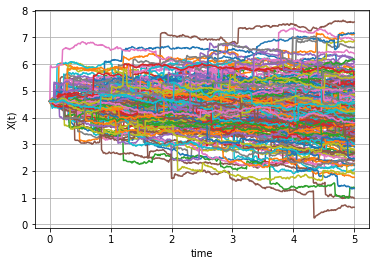

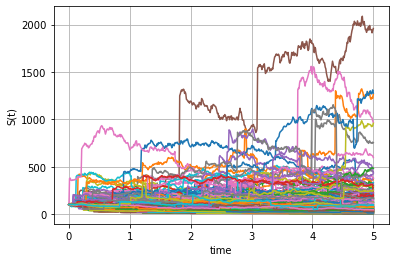

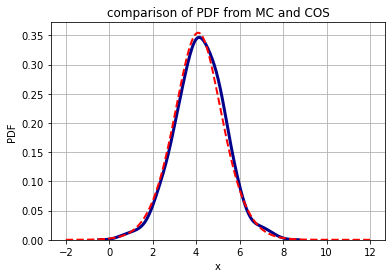

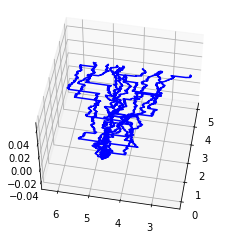

In [8]:
mainCalculation()